Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pandas as pd
import shutil
import random
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
import time
from datetime import datetime
import datetime as dt
import copy
from efficientnet_pytorch import EfficientNet
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

In [2]:
from data_setup import copy_images_to_folders
from image_check import imshow
from model import CustomEfficientNetB0, validate_model, train_model, plot_metrics, visualize_model
from uncertainty_metrics import calculate_risks, process_labels, calculate_and_append_risks, calculate_and_append_risks_by_class, calculate_softmax_uncertainties, calculate_top2_softmax_uncertainties, calculate_random_uncertainties, calculate_mc_dropout_uncertainties_by_sample, calculate_mc_dropout_uncertainties_by_class, calculate_variance_uncertainties, calculate_variational_ratio_uncertainties, calculate_entropy_uncertainties, calculate_predictive_entropy_uncertainties, calculate_mutual_information_uncertainties, smooth_calcs, calculate_aurc, plot_risk_coverage, process_uncertainties, calculate_variational_ratio_dropout_uncertainties, calculate_mutual_information_mc_dropout, select_desired_metrics

In [3]:
# use best algorithm for hardware
cudnn.benchmark = True

# interactive mode for graph plot
plt.ion()

# set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


Sort data into folders based on class

In [ ]:
csv_path = 'data/ISIC_2019_Training_GroundTruth.csv'
image_folder = 'data/ISIC_2019_Resized'
output_folder = 'data/ISIC_Sorted'

copy_images_to_folders(csv_path, image_folder, output_folder)

print("done")

Split data into training, validation and test

In [4]:
# declare variables for model creation
input_folder = 'data/ISIC_Sorted'  # This is the folder containing class subdirectories
output_folder = 'data/data_subset'  # The desired output folder for "training" and "validation" folders
sample_limit=None #None or a number up to 12875
train_ratio=0.6
val_ratio=0.2
test_ratio=0.2

if train_ratio+val_ratio+test_ratio != 1:
    print("invalid data ratios")

set_batch_size=64

#sample numbers by class copied here for reference
#MEL	NV	    BCC	    AK	 BKL	DF	VASC  SCC	UNK
#4522	12875	3323	867	 2624	239	253	  628	0

print("done")

done


In [5]:
training_folder = os.path.join(output_folder, 'train')
validation_folder = os.path.join(output_folder, 'val')
test_folder = os.path.join(output_folder, 'test')

In [ ]:
# Remove existing "training" and "validation" folders if they exist
shutil.rmtree(training_folder, ignore_errors=True)
shutil.rmtree(validation_folder, ignore_errors=True)
shutil.rmtree(test_folder, ignore_errors=True)

# Create the "training" and "validation" folders
os.makedirs(training_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# generate list of class names from the folder structure
class_names = [class_name for class_name in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, class_name))]

print("done")

In [ ]:
# Iterate through each class folder
for class_name in os.listdir(input_folder):
    class_folder_input = os.path.join(input_folder, class_name)
    if os.path.isdir(class_folder_input):
        # Get a list of all images in the class folder
        images = [img for img in os.listdir(class_folder_input) if img.endswith('.jpg')]
        
        # Limit the number of samples if sample_limit is provided
        if sample_limit is not None:
            images = images[:sample_limit]

        # Randomly shuffle the list of images
        np.random.seed(42)
        np.random.shuffle(images)

        # Calculate the number of samples for training and validation
        class_size = len(images)
        num_training_samples = int(class_size * train_ratio)
        num_val_samples = int(class_size * val_ratio)
        num_test_samples = int(class_size * test_ratio)

        # Create the class subfolders within the output folders
        class_folder_training = os.path.join(training_folder, class_name)
        class_folder_validation = os.path.join(validation_folder, class_name)
        class_folder_test = os.path.join(test_folder, class_name)
        os.makedirs(class_folder_training, exist_ok=True)
        os.makedirs(class_folder_validation, exist_ok=True)
        os.makedirs(class_folder_test, exist_ok=True)

        # Copy images to the training folder
        for image_name in images[:num_training_samples]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_training)
        # Copy images to the validation folder
        for image_name in images[num_training_samples:num_training_samples + num_val_samples]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_validation)
        # Copy images to the test folder
        for image_name in images[num_training_samples + num_val_samples:]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_test)

print("done")

In [ ]:
#remove unknown folder as no samples
shutil.rmtree("data/data_subset/train/UNK", ignore_errors=True)
shutil.rmtree("data/data_subset/val/UNK", ignore_errors=True)
shutil.rmtree("data/data_subset/test/UNK", ignore_errors=True)

In [6]:
#transform data
data_transforms = {
'train': transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=360),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), shear=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'test': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
}

In [7]:
# create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(output_folder, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=set_batch_size, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

#print checks to see if the values are the same - if yes then can remove the assignment here
class_names = image_datasets['train'].classes
num_classes = len(class_names)
print(f"file: ", class_names)

file:  ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


show sample images

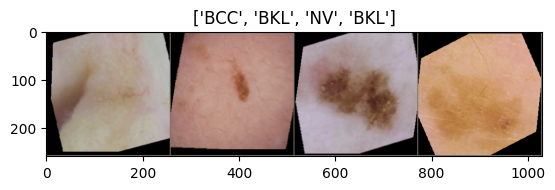

In [8]:
# Specify the number of images to display
num_images = 4

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Select a subset of images
inputs_subset = inputs[:num_images]
classes_subset = classes[:num_images]

# Make a grid from the subset
out = torchvision.utils.make_grid(inputs_subset)

imshow(out, title=[class_names[x] for x in classes_subset])

temporary fix for efficientnet weights issue

In [9]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model fitting configuration

In [10]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_epoch = 1

# Initialize the custom model with dropout
model_ft = CustomEfficientNetB0(num_classes=num_classes, dropout_prob=0.4)

# Move the model to the specified device (e.g., GPU or CPU)
model_ft = model_ft.to(device)

# Define the loss function (cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Use the Adam optimizer for training
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Define a learning rate scheduler to decay the learning rate
# by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b0


In [ ]:
# Get all labels from the training dataset
all_labels = torch.cat([labels for _, labels in dataloaders['train']])

# Count occurrences of each class label
class_counts = torch.bincount(all_labels, minlength=len(image_datasets['train'].classes))

# Calculate class weights
total_samples = class_counts.sum().item()
class_weights = (1 / class_counts.float()) * (total_samples / len(class_counts))

# Print class weights
print("Class Weights:", class_weights)

# Convert class weights to tensor and move to device
class_weights_tensor = class_weights.to(device)

# Define the loss function (cross-entropy loss) with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
# Define the class weights matrices
equal_class_weights_matrix = torch.tensor([
    [0, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 0, 1, 1, 1, 1, 1],
    [1, 1, 1, 0, 1, 1, 1, 1],
    [1, 1, 1, 1, 0, 1, 1, 1],
    [1, 1, 1, 1, 1, 0, 1, 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 0]
], dtype=torch.float)

custom_class_weights_matrix = torch.tensor([
    [0,  1,  20,  20,  10, 20,  10, 1],
    [1,  0,  30,  30,  10, 30,  10, 1],
    [10, 10, 0,   1,   10, 1,   10, 10],
    [10, 10, 1,   0,   10, 1,   10, 10],
    [10, 10, 150, 150, 0,  150, 1,  10],
    [10, 10, 1,   1,   10, 0,   10, 10],
    [10, 10, 150, 150, 1,  150, 0,  10],
    [1,  1,  20,  20,  10, 20,  10, 0]
], dtype=torch.float)

# Normalize each matrix
equal_class_weights_matrix = equal_class_weights_matrix / equal_class_weights_matrix.sum(dim=1, keepdim=True) * 10
custom_class_weights_matrix = custom_class_weights_matrix / custom_class_weights_matrix.sum(dim=1, keepdim=True) * 10

# Print the normalized matrices
print("Equal Cost Matrix:")
print(equal_class_weights_matrix)
print("\nCustom Cost Matrix:")
print(custom_class_weights_matrix)

In [ ]:
# Initialize class counts dictionary and total samples count
class_counts = {class_idx: 0 for class_idx in range(len(image_datasets['train'].classes))}
total_samples = 0

# Iterate over training dataloader to count samples for each class
for inputs, labels in dataloaders['train']:
    for label in labels:
        class_counts[label.item()] += 1
        total_samples += 1

# Calculate class weights using the formula
class_weights = {}
for class_idx, count in class_counts.items():
    class_weights[class_idx] = (1 / count) * (total_samples / len(class_counts))

# Convert class weights to tensor of type torch.float
class_weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float)

# Balance the custom class weights matrix using the calculated class weights
balanced_class_weights_matrix = custom_class_weights_matrix.clone()  # Create a copy to preserve the original
for class_idx, weight in class_weights.items():
    balanced_class_weights_matrix[:, class_idx] *= weight

# Print the balanced class weights matrix
print("Balanced Class Weights Matrix:")
print(balanced_class_weights_matrix)

# Define the custom loss function
class CustomLoss(nn.Module):
    def __init__(self, class_weights_matrix):
        super(CustomLoss, self).__init__()
        self.class_weights_matrix = class_weights_matrix

    def forward(self, outputs, targets):
        # Move class_weights_matrix to the same device as outputs
        class_weights_matrix = self.class_weights_matrix.to(outputs.device)

        # Compute the cross-entropy loss
        loss = nn.CrossEntropyLoss(reduction='none')(outputs, targets)

        # Extract the class weights for each combination of actual and predicted labels
        weights = class_weights_matrix[targets, torch.argmax(outputs, dim=1)]

        # Multiply the cross-entropy loss by the corresponding class weights
        weighted_loss = loss * weights

        # Calculate the mean loss
        mean_loss = torch.mean(weighted_loss)

        return mean_loss

# Define the loss function using the custom loss
criterion = CustomLoss(balanced_class_weights_matrix).to(device)

In [ ]:
# Convert targets to tensor
targets_tensor = torch.tensor(image_datasets['train'].targets)

# Calculate class weights directly using torch
class_counts = torch.bincount(targets_tensor)
total_samples = class_counts.sum().item()
class_weights = (total_samples / (len(image_datasets['train'].classes) * class_counts.float())).tolist()

print("Class Counts:", class_counts)
print("Total Samples:", total_samples)
print("Class Weights:", class_weights)

# Balance the custom class weights matrix using the calculated class weights
balanced_class_weights_matrix = equal_class_weights_matrix.clone()
balanced_class_weights_matrix *= torch.tensor(class_weights, dtype=torch.float).unsqueeze(0)

print("Balanced Class Weights Matrix:")
print(balanced_class_weights_matrix)

# Define the custom loss function
class CustomLoss(nn.Module):
    def __init__(self, class_weights_matrix):
        super(CustomLoss, self).__init__()
        self.class_weights_matrix = class_weights_matrix

    def forward(self, outputs, targets):
        # Compute the cross-entropy loss
        loss = nn.CrossEntropyLoss(reduction='none')(outputs, targets)

        # Extract the class weights for each combination of actual and predicted labels
        weights = self.class_weights_matrix[targets, torch.argmax(outputs, dim=1)]

        # Multiply the cross-entropy loss by the corresponding class weights
        weighted_loss = loss * weights

        # Calculate the mean loss
        mean_loss = torch.mean(weighted_loss)

        return mean_loss

# Define the loss function using the custom loss
criterion = CustomLoss(balanced_class_weights_matrix)

In [11]:
def compute_class_weights(targets, num_classes):
    class_counts = torch.bincount(targets, minlength=num_classes)
    total_samples = class_counts.sum().item()
    class_weights = (total_samples / (num_classes * class_counts.float())).tolist()
    return class_weights

def normalize_matrix(matrix):
    return matrix / matrix.sum(dim=1, keepdim=True)

def print_matrix(label, matrix):
    print(label + ":")
    print(matrix)

In [28]:
# Convert targets to tensor and move to device
targets_tensor = torch.tensor(image_datasets['train'].targets).to(device)

# Compute class weights
class_weights = compute_class_weights(targets_tensor, len(image_datasets['train'].classes))

# Print class weights
print("Class Weights:", class_weights)

Class Weights: [3.652644157409668, 0.9530230760574341, 1.2067184448242188, 13.282342910766602, 0.700101375579834, 0.24587377905845642, 5.0515289306640625, 12.578642845153809]


In [29]:
# Define the class weights matrices and move to device
equal_class_weights_matrix = torch.tensor([
    [0, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 0, 1, 1, 1, 1, 1],
    [1, 1, 1, 0, 1, 1, 1, 1],
    [1, 1, 1, 1, 0, 1, 1, 1],
    [1, 1, 1, 1, 1, 0, 1, 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 0]
], dtype=torch.float).to(device)

custom_class_weights_matrix = torch.tensor([
    [0,  1,  20,  20,  10, 20,  10, 1],
    [1,  0,  30,  30,  10, 30,  10, 1],
    [10, 10, 0,   1,   10, 1,   10, 10],
    [10, 10, 1,   0,   10, 1,   10, 10],
    [10, 10, 150, 150, 0,  150, 1,  10],
    [10, 10, 1,   1,   10, 0,   10, 10],
    [10, 10, 150, 150, 1,  150, 0,  10],
    [1,  1,  20,  20,  10, 20,  10, 0]
], dtype=torch.float).to(device)

equal_class_weights_matrix = normalize_matrix(equal_class_weights_matrix)
custom_class_weights_matrix = normalize_matrix(custom_class_weights_matrix)

# Print the normalized matrices
print_matrix("Equal Cost Matrix", equal_class_weights_matrix)
print_matrix("Custom Cost Matrix", custom_class_weights_matrix)

Equal Cost Matrix:
tensor([[0.0000, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429],
        [0.1429, 0.0000, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429],
        [0.1429, 0.1429, 0.0000, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429],
        [0.1429, 0.1429, 0.1429, 0.0000, 0.1429, 0.1429, 0.1429, 0.1429],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.0000, 0.1429, 0.1429, 0.1429],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000, 0.1429, 0.1429],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000, 0.1429],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000]],
       device='cuda:0')
Custom Cost Matrix:
tensor([[0.0000, 0.0122, 0.2439, 0.2439, 0.1220, 0.2439, 0.1220, 0.0122],
        [0.0089, 0.0000, 0.2679, 0.2679, 0.0893, 0.2679, 0.0893, 0.0089],
        [0.1923, 0.1923, 0.0000, 0.0192, 0.1923, 0.0192, 0.1923, 0.1923],
        [0.1923, 0.1923, 0.0192, 0.0000, 0.1923, 0.0192, 0.1923, 0.1923],
        [0.0208, 0.0208, 0.3119, 0.3119, 0.0000,

In [30]:
# Balance the custom class weights matrix using the calculated class weights
balanced_class_weights_matrix = equal_class_weights_matrix * torch.tensor(class_weights, dtype=torch.float).unsqueeze(0).to(device) * 7

print_matrix("Balanced Class Weights Matrix", balanced_class_weights_matrix)

Balanced Class Weights Matrix:
tensor([[ 0.0000,  0.9530,  1.2067, 13.2823,  0.7001,  0.2459,  5.0515, 12.5786],
        [ 3.6526,  0.0000,  1.2067, 13.2823,  0.7001,  0.2459,  5.0515, 12.5786],
        [ 3.6526,  0.9530,  0.0000, 13.2823,  0.7001,  0.2459,  5.0515, 12.5786],
        [ 3.6526,  0.9530,  1.2067,  0.0000,  0.7001,  0.2459,  5.0515, 12.5786],
        [ 3.6526,  0.9530,  1.2067, 13.2823,  0.0000,  0.2459,  5.0515, 12.5786],
        [ 3.6526,  0.9530,  1.2067, 13.2823,  0.7001,  0.0000,  5.0515, 12.5786],
        [ 3.6526,  0.9530,  1.2067, 13.2823,  0.7001,  0.2459,  0.0000, 12.5786],
        [ 3.6526,  0.9530,  1.2067, 13.2823,  0.7001,  0.2459,  5.0515,  0.0000]],
       device='cuda:0')


In [31]:
# Define the custom loss function
class CustomLoss(nn.Module):
    def __init__(self, class_weights_matrix):
        super(CustomLoss, self).__init__()
        self.class_weights_matrix = class_weights_matrix.to(device)

    def forward(self, outputs, targets):
        # Compute the cross-entropy loss
        loss = nn.CrossEntropyLoss(reduction='none')(outputs, targets)

        # Extract the class weights for each combination of actual and predicted labels
        weights = self.class_weights_matrix[targets, torch.argmax(outputs, dim=1)]

        # Multiply the cross-entropy loss by the corresponding class weights
        weighted_loss = loss * weights

        # Calculate the mean loss
        mean_loss = torch.mean(weighted_loss)

        return mean_loss

# Define the loss function using the custom loss
criterion = CustomLoss(balanced_class_weights_matrix)

In [32]:
model_ft = model_ft.to(device)

In [33]:
def validate_model(model, criterion, data_loader, device, num_val_mc_samples=100, num_classes=1):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs_list = [model(inputs).unsqueeze(0) for _ in range(num_val_mc_samples)]
            outputs_mean = torch.cat(outputs_list, dim=0).mean(dim=0)
            
            # Normalize the loss by the number of classes
            loss = criterion(outputs_mean, labels) / num_classes
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs_mean, 1)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)
    
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = running_corrects.double() / len(data_loader.dataset)
    return epoch_loss, epoch_acc

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, train_losses, train_accuracies, val_losses, val_accuracies, best_epoch, num_epochs=50, num_val_mc_samples=100, loss_weight=1, acc_weight=0, num_classes=1, save_dir="saved_models", resume_training=False):
    since = time.time()

    best_combined_metric = -float('inf')  # Initialize to negative infinity
    best_val_loss = float('inf')  # Initialize to positive infinity
    best_val_acc = 0.0
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    if resume_training:
        checkpoint = torch.load(os.path.join(save_dir, 'checkpoint.pth.tar'))
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_combined_metric = checkpoint['best_combined_metric']
        best_val_loss = checkpoint['best_val_loss']
        best_val_acc = checkpoint['best_val_acc']
        best_epoch = checkpoint['best_epoch']
        train_losses = checkpoint['train_losses']
        train_accuracies = checkpoint['train_accuracies']
        val_losses = checkpoint['val_losses']
        val_accuracies = checkpoint['val_accuracies']

    for epoch in range(num_epochs):
        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f'Epoch {epoch + 1}/{num_epochs} - {current_time}')
        print('-' * 10)

        for phase in ['train', 'val']:
            model.train(phase == 'train')
            data_loader = dataloaders[phase]

            if phase == 'train':
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                
                for inputs, labels in data_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    outputs = outputs.to(device)  # Move outputs to device
                    loss = criterion(outputs, labels)
                    
                    # Apply class-wise normalization
                    loss = loss / num_classes
                    loss = loss.to(device)  # Move loss to device
                    
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += labels.size(0)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / total_samples
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}, {phase.capitalize()} Acc: {epoch_acc:.4f}')
                
                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc)
                
            else:
                epoch_loss, epoch_acc = validate_model(model, criterion, data_loader, device, num_val_mc_samples, num_classes)
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}, {phase.capitalize()} Acc: {epoch_acc:.4f}')
                print()
                
                # Calculate combined metric
                combined_metric = (acc_weight * epoch_acc) - (loss_weight * epoch_loss)
                if combined_metric > best_combined_metric:
                    best_combined_metric = combined_metric
                    best_val_loss = epoch_loss
                    best_val_acc = epoch_acc
                    best_epoch = epoch + 1  # Store the epoch number
                    torch.save(model.state_dict(), os.path.join(save_dir, 'best_model_params.pth'))
                    
        # Save checkpoint
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_combined_metric': best_combined_metric,
            'best_val_loss': best_val_loss,
            'best_val_acc': best_val_acc,
            'best_epoch': best_epoch,
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        }
        torch.save(checkpoint, os.path.join(save_dir, 'checkpoint.pth.tar'))

    print(f'Best combined metric: {best_combined_metric:.4f}')
    print(f'Loss associated with the best combined metric: {best_val_loss:.4f}')
    print(f'Accuracy associated with the best combined metric: {best_val_acc:.4f}')
    print(f'Epoch associated with the best model: {best_epoch}')
    print()
    model.load_state_dict(torch.load(os.path.join(save_dir, 'best_model_params.pth')))

In [ ]:
train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, device, train_losses, train_accuracies, val_losses, val_accuracies, best_epoch, num_epochs=2, num_val_mc_samples=1, loss_weight=1, acc_weight=0, num_classes=num_classes, save_dir="test", resume_training=False)

Epoch 1/2 - 2024-03-21 02:33:36
----------


In [ ]:
# Load the checkpoint
#checkpoint = torch.load('equal_weights/checkpoint.pth.tar')
#checkpoint = torch.load('custom_weights_matrix/checkpoint.pth.tar')
checkpoint = torch.load('equal_weights_matrix/checkpoint.pth.tar')

# Load model state_dict
model_ft.load_state_dict(checkpoint['model_state_dict'])

# Load optimizer state_dict
optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])

# Load scheduler state_dict
exp_lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Retrieve other variables
best_combined_metric = checkpoint['best_combined_metric']
best_val_loss = checkpoint['best_val_loss']
best_val_acc = checkpoint['best_val_acc']
best_epoch = checkpoint['best_epoch']
train_losses = checkpoint['train_losses']
train_accuracies = checkpoint['train_accuracies']
val_losses = checkpoint['val_losses']
val_accuracies = checkpoint['val_accuracies']

In [ ]:
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, best_epoch)

visualise trained model

In [ ]:
visualize_model(model_ft, dataloaders['val'], device, class_names, num_images=4)

In [ ]:
def calculate_softmax_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():
        # for every batch in the dataloader
        for inputs, labels in dataloader:
            #get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            # get the outputs
            outputs = model(inputs, dropout=False).to(device)  # Move outputs to device
            # get the softmax outputs
            probabilities = F.softmax(outputs, dim=1).to(device)  # Move probabilities to device
            # get the class predictions
            _, predicted = torch.max(outputs, 1)
            # check and store whether predictions are correct
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Compute uncertainty based on softmax probabilities
            for idx in range(len(predicted)):
                predicted_class = predicted[idx].item()
                uncertainty = 1.0 - probabilities[idx, predicted_class].item()  # Using confidence as uncertainty
                uncertainties.append(uncertainty)

    return guesses_are_correct, uncertainties, sample_labels


def calculate_top2_softmax_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():
        # For every batch in the dataloader
        for inputs, labels in dataloader:
            # Get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            # Get the outputs
            outputs = model(inputs, dropout=False).to(device)  # Move outputs to device
            # Get the softmax outputs
            probabilities = F.softmax(outputs, dim=1).to(device)  # Move probabilities to device
            # Get the top two softmax values and their indices
            top2_probs, top2_indices = torch.topk(probabilities, k=2, dim=1)

            # Get the difference between the top two softmax values
            top2_diff = top2_probs[:, 0] - top2_probs[:, 1]

            # Get the class predictions
            _, predicted = torch.max(outputs, 1)
            # Check and store whether predictions are correct
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Store the uncertainty as the difference between the top two softmax values
            uncertainties.extend(-top2_diff.cpu().numpy())

    return guesses_are_correct, uncertainties, sample_labels


def calculate_random_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            outputs = model(inputs, dropout=False).to(device)
            _, predicted = torch.max(outputs, 1)
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Generate a single random uncertainty value for each predicted class
            for idx in range(len(predicted)):
                uncertainty = random.random()
                uncertainties.append(uncertainty)

    return guesses_are_correct, uncertainties, sample_labels

def calculate_mc_dropout_uncertainties_by_sample(model, dataloader, class_names, device, num_samples=100):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            mean_predictions = torch.zeros(num_samples, inputs.size(0), len(class_names)).to(device)

            # Generate predictions with dropout for multiple samples
            for i in range(num_samples):
                outputs = model(inputs)
                predictions = F.softmax(outputs, dim=1).to(device)  # Move softmax operation to device
                mean_predictions[i] = predictions

            # Calculate mean prediction across samples
            mean_prediction = torch.mean(mean_predictions, dim=0)

            # Calculate uncertainty using mean prediction
            uncertainties.extend(1.0 - torch.max(mean_prediction, dim=1)[0].cpu().numpy())

            # Determine correctness of predictions
            _, predicted = torch.max(mean_prediction, 1)
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Print date/time for monitoring
            print(f"{dt.datetime.now()} - Batch {batch_idx + 1}/{len(dataloader)} processed")

    return guesses_are_correct, uncertainties, sample_labels

def calculate_mc_dropout_uncertainties_by_class(model, dataloader, class_names, device, num_samples=100):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            logits_list = []  # Initialize a list to store logits for each sample

            # Generate predictions with dropout for multiple samples
            for i in range(num_samples):
                outputs = model(inputs)
                logits_list.append(outputs)

            # Concatenate logits along a new dimension to create a tensor
            logits_tensor = torch.stack(logits_list, dim=0).to(device)

            # Calculate average output across all samples for each class
            class_avg_outputs = torch.mean(logits_tensor, dim=0)

            # Calculate uncertainty using the highest average output
            uncertainties.extend(1.0 - torch.max(class_avg_outputs, dim=1)[0].cpu().numpy())

            # Determine correctness of predictions
            _, predicted = torch.max(class_avg_outputs, 1)
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Print date/time for monitoring
            print(f"{dt.datetime.now()} - Batch {batch_idx + 1}/{len(dataloader)} processed")

    return guesses_are_correct, uncertainties, sample_labels

def calculate_variance_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():
        # For every batch in the dataloader
        for inputs, labels in dataloader:
            # Get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            # Get the outputs
            outputs = model(inputs, dropout=False).to(device)  # Move outputs to device
            # Get the softmax outputs
            probabilities = F.softmax(outputs, dim=1).to(device)  # Move probabilities to device
            # Get the class predictions
            _, predicted = torch.max(outputs, 1)
            # Check and store whether predictions are correct
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Compute uncertainty based on variance over classes
            variance = torch.var(probabilities, dim=1)
            uncertainties.extend(-variance.cpu().numpy())

    return guesses_are_correct, uncertainties, sample_labels

def calculate_variational_ratio_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():
        # For every batch in the dataloader
        for inputs, labels in dataloader:
            # Get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            # Get the outputs
            outputs = model(inputs, dropout=False).to(device)  # Move outputs to device
            # Get the softmax outputs
            probabilities = F.softmax(outputs, dim=1).to(device)  # Move probabilities to device
            # Get the class predictions
            _, predicted = torch.max(outputs, 1)
            # Check and store whether predictions are correct
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Compute uncertainty based on Variational Ratios
            mode_probabilities, _ = torch.max(probabilities, dim=1, keepdim=True)
            other_probabilities = probabilities.clone()
            other_probabilities.scatter_(1, predicted.view(-1, 1), 0)  # Set mode probabilities to 0
            max_other_probabilities, _ = torch.max(other_probabilities, dim=1, keepdim=True)
            variational_ratio = 1.0 - mode_probabilities / max_other_probabilities
            uncertainties.extend(variational_ratio.cpu().numpy())

    return guesses_are_correct, uncertainties, sample_labels

def calculate_variational_ratio_dropout_uncertainties(model, dataloader, class_names, device, num_samples=100):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():
        # For every batch in the dataloader
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            # Get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            predictions = []
            for _ in range(num_samples):
                # Get the outputs with dropout
                outputs = model(inputs, dropout=True).to(device)  # Move outputs to device
                predictions.append(F.softmax(outputs, dim=1).cpu().numpy())

            predictions = torch.tensor(np.array(predictions)).to(device)

            # Compute mean probabilities and uncertainties based on Variational Ratios
            mean_probabilities = torch.mean(predictions, dim=0)
            mode_probabilities, _ = torch.max(mean_probabilities, dim=1, keepdim=True)
            other_probabilities = mean_probabilities.clone()
            other_probabilities.scatter_(1, torch.argmax(mean_probabilities, dim=1).view(-1, 1), 0)  # Set mode probabilities to 0
            max_other_probabilities, _ = torch.max(other_probabilities, dim=1, keepdim=True)
            variational_ratio = 1.0 - mode_probabilities / max_other_probabilities
            uncertainties.extend(variational_ratio.cpu().numpy())

            # Get the class predictions
            _, predicted = torch.max(mean_probabilities, 1)
            # Check and store whether predictions are correct
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())
            
            # Print date/time for monitoring
            print(f"{dt.datetime.now()} - Batch {batch_idx + 1}/{len(dataloader)} processed")

    return guesses_are_correct, uncertainties, sample_labels

def calculate_entropy_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():
        # For every batch in the dataloader
        for inputs, labels in dataloader:
            # Get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            # Get the outputs
            outputs = model(inputs, dropout=True).to(device)  # Move outputs to device
            # Get the softmax outputs
            probabilities = F.softmax(outputs, dim=1).to(device)  # Move probabilities to device
            # Get the class predictions
            _, predicted = torch.max(outputs, 1)
            # Check and store whether predictions are correct
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Compute uncertainty based on predictive entropy
            entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1)  # Adding a small value to avoid log(0)
            uncertainties.extend(entropy.cpu().numpy())

    return guesses_are_correct, uncertainties, sample_labels

def calculate_predictive_entropy_uncertainties(model, dataloader, class_names, device, num_samples=100):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            # Get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            entropy_list = []  # Initialize a list to store entropy for each sample

            # Generate predictions with dropout for multiple samples
            for i in range(num_samples):
                # Get the outputs with dropout
                outputs = model(inputs, dropout=True).to(device)  # Move outputs to device
                probabilities = F.softmax(outputs, dim=1).to(device)  # Move probabilities to device
                entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1)  # Adding a small value to avoid log(0)
                entropy_list.append(entropy)  # Store entropy for each sample

            # Concatenate entropies along a new dimension to create a tensor
            entropy_tensor = torch.stack(entropy_list, dim=0).to(device)

            # Calculate average entropy across all samples
            avg_entropy = torch.mean(entropy_tensor, dim=0)

            uncertainties.extend(avg_entropy.cpu().numpy())

            # Get the class predictions based on the maximum probability
            _, predicted = torch.max(outputs, 1)

            # Determine correctness of predictions
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Print date/time for monitoring
            print(f"{dt.datetime.now()} - Batch {batch_idx + 1}/{len(dataloader)} processed")

    return guesses_are_correct, uncertainties, sample_labels


def calculate_mutual_information_uncertainties(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    guesses_are_correct = []
    uncertainties = []
    sample_labels = []

    with torch.no_grad():
        # For every batch in the dataloader
        for inputs, labels in dataloader:
            # Get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            # Get the outputs
            outputs = model(inputs, dropout=False).to(device)  # Move outputs to device
            # Get the softmax outputs
            probabilities = F.softmax(outputs, dim=1).to(device)  # Move probabilities to device
            # Get the class predictions
            _, predicted = torch.max(outputs, 1)
            # Check and store whether predictions are correct
            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Compute uncertainty based on mutual information
            uniform_distribution = torch.full_like(probabilities, 1.0 / probabilities.size(1)).to(device)  # Move uniform_distribution to device
            mutual_information = F.kl_div(probabilities.log(), uniform_distribution, reduction='none').sum(dim=1)
            uncertainties.extend(-mutual_information.cpu().numpy())

    return guesses_are_correct, uncertainties, sample_labels

def calculate_mutual_information_mc_dropout(model, dataloader, class_names, device, num_samples=100):
    model.eval()  # Set the model to evaluation mode
    uncertainties = []
    guesses_are_correct = []
    sample_labels = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            # Get the inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            sample_labels.extend(labels.cpu().numpy())

            logits_list = []  # Initialize a list to store logits for each sample

            # Generate predictions with dropout for multiple samples
            for i in range(num_samples):
                # Get the outputs with dropout
                outputs = model(inputs, dropout=True).to(device)  # Move outputs to device
                logits_list.append(outputs)  # Store logits for each sample

            # Concatenate logits along a new dimension to create a tensor
            logits_tensor = torch.stack(logits_list, dim=0).to(device)

            # Calculate softmax probabilities
            probabilities = F.softmax(logits_tensor, dim=2).to(device)

            # Compute uncertainty based on mutual information
            uniform_distribution = torch.full_like(probabilities, 1.0 / probabilities.size(2)).to(device)  # Move uniform_distribution to device
            mutual_information = F.kl_div(probabilities.log(), uniform_distribution, reduction='none').sum(dim=2)

            # Average mutual information across samples
            avg_mutual_information = mutual_information.mean(dim=0)

            # Store mutual information
            uncertainties.extend(-avg_mutual_information.cpu().numpy())

            # Determine correctness of predictions
            _, predicted = torch.max(logits_tensor.mean(dim=0), 1)

            correct_guesses = (predicted == labels)
            guesses_are_correct.extend(correct_guesses.cpu().numpy())

            # Print date/time for monitoring
            print(f"{dt.datetime.now()} - Batch {batch_idx + 1}/{len(dataloader)} processed")

    return guesses_are_correct, uncertainties, sample_labels

In [ ]:
# Lists to store results
risks_list = []
labels_list = []

risks_list_by_class = [[] for _ in range(len(class_names))]
labels_list_by_class = [[] for _ in range(len(class_names))]

uncertainty_functions = [
    (calculate_softmax_uncertainties, "Softmax Response"),
    (calculate_top2_softmax_uncertainties, "Top2 Softmax Difference"),
    (calculate_random_uncertainties, "Random Uncertainties"),
    (calculate_mc_dropout_uncertainties_by_sample, "MCD By Sample", {"num_samples": 100}),
    (calculate_mc_dropout_uncertainties_by_class, "MCD By Class", {"num_samples": 100}),
    (calculate_variance_uncertainties, "Variance"),
    (calculate_variational_ratio_uncertainties, "Variational Ratio"),
    (calculate_variational_ratio_dropout_uncertainties, "Variational Ratio with Dropout", {"num_samples": 100}),
    (calculate_entropy_uncertainties, "Entropy"),
    (calculate_predictive_entropy_uncertainties, "Predictive Entropy", {"num_samples": 100}),
    (calculate_mutual_information_uncertainties, "Mutual Information"),
    (calculate_mutual_information_mc_dropout, "Mutual Information with Dropout", {"num_samples": 100})
]

for function, name, *args in uncertainty_functions:
    if args:  # Check if additional arguments exist
        additional_args = args[0]  # Extract additional arguments
        process_uncertainties(risks_list, labels_list, risks_list_by_class, labels_list_by_class, model_ft, dataloaders['test'], class_names, device, function, name, **additional_args)  # Pass additional arguments as keyword arguments
    else:
        process_uncertainties(risks_list, labels_list, risks_list_by_class, labels_list_by_class, model_ft, dataloaders['test'], class_names, device, function, name)

print("Done")

In [ ]:
description_list = [
    "Softmax Response measures the model's confidence in its predictions based on the softmax probabilities.",
    "Top2 Softmax Difference measures the uncertainty by calculating the difference between the top two softmax probabilities",
    "Random Uncertainties assigns random uncertainty values to each prediction, providing a baseline comparison for uncertainty estimation methods.",
    "MCD By Sample utilizes Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout.",
    "MCD By Class employs Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout for each class.",
    "Variance calculates uncertainty by computing the variance of softmax probabilities across classes for each prediction.",
    "Variational Ratio calculates uncertainty by computing the ratio of the maximum softmax probability (mode probability) to the maximum probability among other classes for each prediction.",
    "Entropy calculates uncertainty by measuring the entropy of softmax probabilities for each prediction.",
    "Predictive Entropy estimates uncertainty by averaging the entropy of softmax probabilities across multiple samples generated with dropout.",
    "Mutual Information computes uncertainty by measuring the mutual information between the model's softmax probabilities and a uniform distribution."
]

for description in description_list:
    print(f"- {description}")

print(
"""
- Risk = 1 - Accuracy, where Accuracy is the mean accuracy (normalised) over the samples included in the Coverage.
- Coverage is the normalised number of samples over the total samples. Coverage decreases as the most uncertain samples are removed.
- Area Under Risk Coverage (AURC) is the area under the Risk Coverage curve.

- Classes:
    - Melanoma (MEL)
    - Melanocytic nevus (NV)
    - Basal cell carcinoma (BCC)
    - Actinic keratosis (AK)
    - Benign keratosis (BKL) 
        [solar lentigo / seborrheic keratosis / lichen planus-like keratosis]
    - Dermatofibroma (DF)
    - Vascular lesion (VASC)
    - Squamous cell carcinoma (SCC)
    - None of the others (UNK)
"""
)

In [ ]:
# Define the desired metrics to plot
# comment out undesired metrics
desired_metrics = [
    "Softmax Response",
    "Top2 Softmax Difference",
    "Random Uncertainties",
    "MCD By Sample",
    "MCD By Class",
    "Variance",
    "Variational Ratio",
    "Variational Ratio with Dropout",
    "Entropy",
    "Predictive Entropy",
    "Mutual Information",
    "Mutual Information with Dropout"
]

# Select desired metrics for all samples
selected_labels_list, selected_risks_list = select_desired_metrics(labels_list, risks_list, desired_metrics)

# Print information about all classes
print(f"All Classes: {len(selected_risks_list[0])} samples")
x_smooth_percentage_interp, x_smooth_percentage = smooth_calcs(selected_risks_list[0])
calculate_aurc(selected_risks_list, selected_labels_list, x_smooth_percentage_interp, x_smooth_percentage)
plot_risk_coverage(selected_risks_list, selected_labels_list, x_smooth_percentage_interp, x_smooth_percentage)

# Iterate over each class
for i in range(len(class_names)):
    # Select desired metrics for the current class
    selected_labels_list_class, selected_risks_list_class = select_desired_metrics(labels_list_by_class[i], risks_list_by_class[i], desired_metrics)
    
    # Print information about the current class
    print(f"{class_names[i]}: {len(selected_risks_list_class[0])} samples")
    x_smooth_percentage_interp, x_smooth_percentage = smooth_calcs(selected_risks_list_class[0])
    calculate_aurc(selected_risks_list_class, selected_labels_list_class, x_smooth_percentage_interp, x_smooth_percentage)
    plot_risk_coverage(selected_risks_list_class, selected_labels_list_class, x_smooth_percentage_interp, x_smooth_percentage)
    print()

print("done")